In [1]:
import sys
sys.path.append('../lib')
import json
import pandas as pd
import matplotlib.pyplot as plt
from random_eraser import get_random_eraser
import numpy as np
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter
import cv2
import json
import editdistance
from PIL import Image

%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 5)

/home/pbcquoc/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
labels = json.load(open('../../data/ocr/labels.json'))

In [3]:
y = pd.DataFrame(list(labels.values()), columns=['y'])

In [4]:
y['length'] = y['y'].str.len()
y['comma'] = y['y'].str.split(',').str.len()

In [5]:
y.head()

,y,length,comma
0,"Số 253 đường Trần Phú, Thị trấn Nam Sách, Huyệ...",67,4
1,"Số 289 Đinh Bộ Lĩnh, Phường 26, Quận Bình Thạn...",63,4
2,"Số 246E/2, Khu phố 1B, Phường An Phú, Tx Thuận...",61,5
3,"42 Đặng Thị Nhu, Phường Nguyễn Thái Bình, Quận...",64,4
4,"200 Phan Bội Châu, Phường Trường An, Thành phố...",68,4


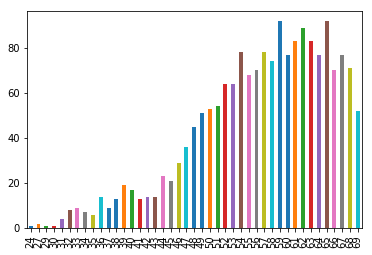

In [6]:
y['length'].value_counts().sort_index().plot.bar()

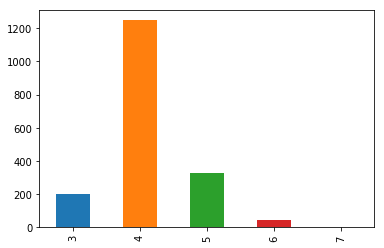

In [7]:
y['comma'].value_counts().sort_index().plot.bar()

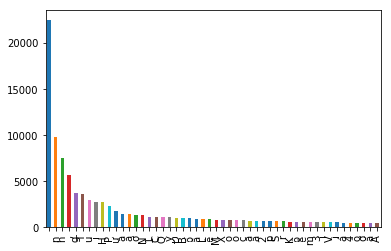

In [8]:
pd.value_counts(list(' '.join(y['y'].values))).head(50).plot.bar()

In [9]:
''.join(sorted(list(set(list(' '.join(y['y'].values))))))

" #'()+,-./0123456789:ABCDEFGHIJKLMNOPQRSTUVWXYabcdeghiklmnopqrstuvxyzÂÊÔàáâãèéêìíòóôõùúýăĐđĩũƠơưạảấầẩậắằẵặẻẽếềểễệỉịọỏốồổỗộớờởỡợụủỨứừửữựỳỵỷỹ"

In [2]:
# Function to distort image
def elastic_transform(image, alpha, sigma, alpha_affine, random_state=None):
    """Elastic deformation of images as described in [Simard2003]_ (with modifications).
    .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for
         Convolutional Neural Networks applied to Visual Document Analysis", in
         Proc. of the International Conference on Document Analysis and
         Recognition, 2003.

     Based on https://gist.github.com/erniejunior/601cdf56d2b424757de5
    """
    if random_state is None:
        random_state = np.random.RandomState(None)

    shape = image.shape
    shape_size = shape[:2]
    
    # Random affine
    center_square = np.float32(shape_size) // 2
    square_size = min(shape_size) // 3
    pts1 = np.float32([center_square + square_size, [center_square[0]+square_size, center_square[1]-square_size], center_square - square_size])
    pts2 = pts1 + random_state.uniform(-alpha_affine, alpha_affine, size=pts1.shape).astype(np.float32)
    M = cv2.getAffineTransform(pts1, pts2)
    image = cv2.warpAffine(image, M, shape_size[::-1], borderMode=cv2.BORDER_REFLECT_101)

    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dz = np.zeros_like(dx)

    x, y, z = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]), np.arange(shape[2]))
    indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1)), np.reshape(z, (-1, 1))

    return map_coordinates(image, indices, order=1, mode='reflect').reshape(shape)

In [3]:
random_eraser = get_random_eraser(p=1, s_l=0.004, s_h=0.005, r_1=0.01, r_2=1/0.01, v_l=0, v_h=1)

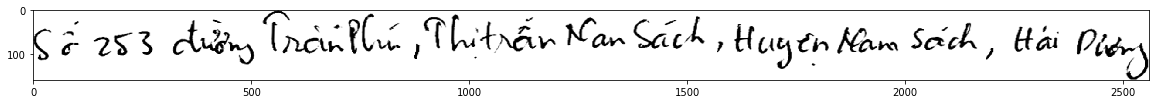

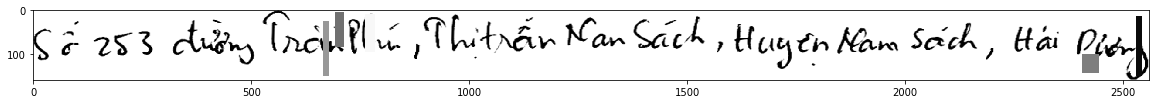

In [11]:
plt.figure(figsize=(20, 10))
img = image.load_img('../../data/ocr/preprocess/train/0000_samples.png', target_size=(160, 2560), interpolation='bicubic')
img = image.img_to_array(img)/255
plt.imshow(img)

img_eraser = random_eraser(img)
for _ in range(4):
    img_eraser = random_eraser(img_eraser)


plt.figure(figsize=(20, 10))
plt.imshow(img_eraser)

In [12]:
image_datagen_args = {
                'shear_range': 0.1,
                'zoom_range': 0.01,
                'width_shift_range': 0.001,
                'height_shift_range': 0.1,
                'rotation_range': 1,
                'horizontal_flip': False,
                'vertical_flip': False
        }
image_datagen = ImageDataGenerator(**image_datagen_args)

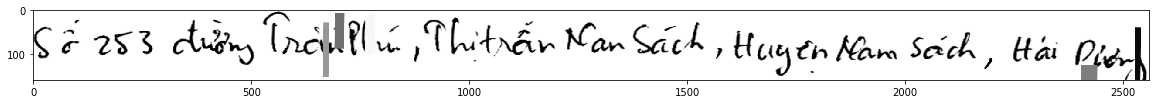

In [13]:
params = image_datagen.get_random_transform(img.shape)
img_aug = image_datagen.apply_transform(img, params)
plt.figure(figsize=(20, 10))
plt.imshow(img_aug)

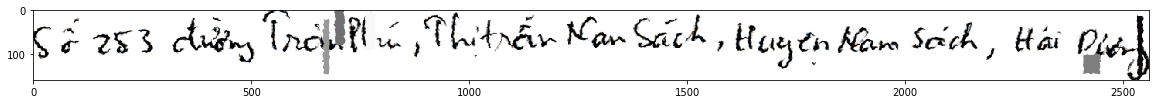

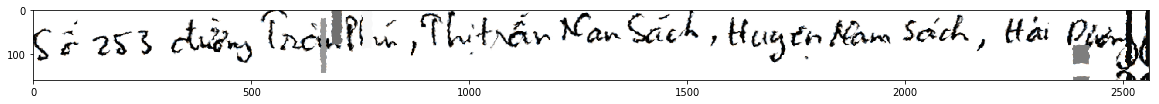

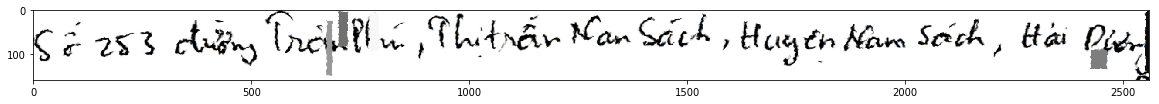

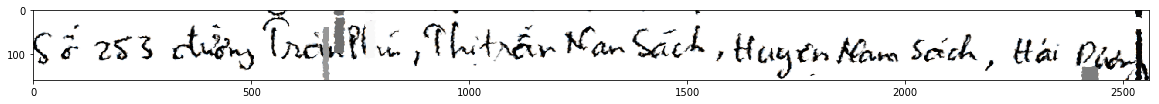

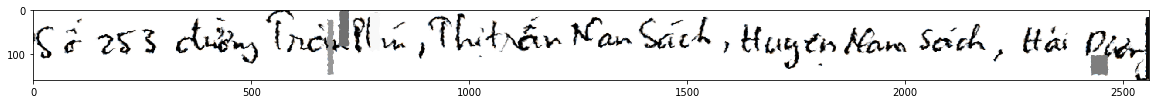

In [14]:
for _ in range(5):
    plt.figure(figsize=(20, 10))
    elastic_img = elastic_transform(img, 20, 2,0.7)
    plt.imshow(elastic_img)

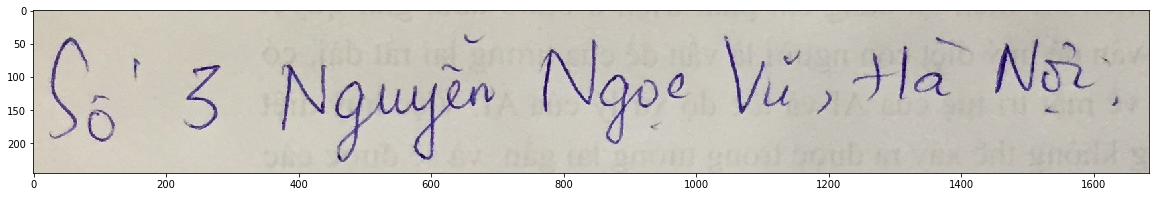

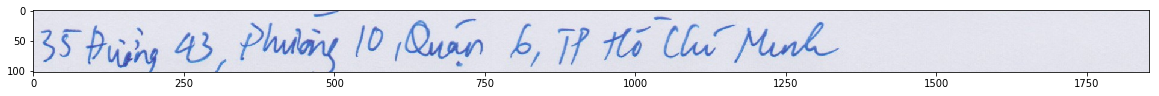

In [31]:
plt.figure(figsize=(20, 10))
img = image.load_img('../../data/ocr/test/1.jpg')
img = image.img_to_array(img)/255
plt.imshow(img)
plt.figure(figsize=(20, 10))
img = image.load_img('../../data/ocr/train/1814_samples.png')
img = image.img_to_array(img)/255
plt.imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


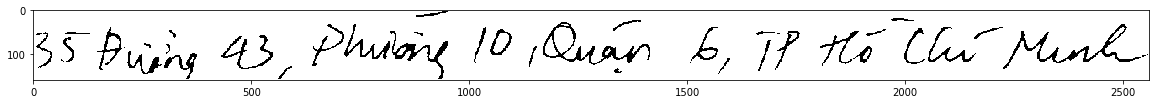

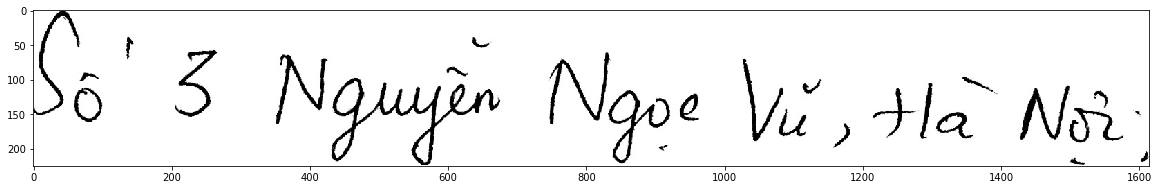

In [14]:
plt.figure(figsize=(20, 10))
img = image.load_img('../../data/ocr/preprocess/train/1814_samples.png', target_size=(160, 2560))
img = image.img_to_array(img)
plt.imshow(img)

plt.figure(figsize=(20, 10))
img = image.load_img('../../data/ocr/preprocess/test/1.jpg')
img = image.img_to_array(img)/255
plt.imshow(img)

In [7]:
test_labels = json.load(open('../../data/ocr/private.json'))
predict = json.load(open('../../data/ocr/predict.json'))

In [8]:
mean_ed = 0.0
mean_norm_ed = 0.0
num = len(test_labels)
for k, v in test_labels.items():
    edit_dist = editdistance.eval(v, predict[k])
    mean_ed += float(edit_dist)
    mean_norm_ed += float(edit_dist) / max(len(predict[k]), len(v))
    
mean_norm_ed = mean_norm_ed / num
mean_ed = mean_ed / num

print("edit distance: {} - normalize edit distance: {} ".format(mean_ed, mean_norm_ed))


edit distance: 3.519125683060109 - normalize edit distance: 0.060539649128239795 
